# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.DataStructs import ConvertToNumpyArray

from rdkit.Chem import PandasTools

In [3]:
# Import PyTorch and its modules
import torch
import torchvision
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Load the data

In [4]:
#
#datapath = os.path.join(".", "tox21.csv")
tox21 = pd.read_csv("tox21.csv")
tox21.head()

,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group
0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train
1,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,train
2,O=C(Nc1c(cccc1C)C)C(N(CCC)CC)CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,train
3,P(O)(O)(=O)C(P(O)(O)=O)(O)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
4,O(OC(C)(C)C)C(CCC(OOC(C)(C)C)(C)C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,train


## Data preprocessing

In [5]:
tox21.describe()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
count,7245.000000,6740.000000,6529.000000,5804.000000,6175.000000,6936.000000,6432.000000,5816.000000,7054.000000,6447.000000,5795.000000,6756.000000
mean,0.042650,0.035015,0.117323,0.051516,0.128421,0.050317,0.028762,0.161279,0.037284,0.057236,0.158240,0.062463
std,0.202081,0.183831,0.321829,0.221067,0.334585,0.218614,0.167151,0.367820,0.189470,0.232311,0.364997,0.242012
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#Generate data exploration
tox21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 14 columns):
cano_smiles      7811 non-null object
NR-AR            7245 non-null float64
NR-AR-LBD        6740 non-null float64
NR-AhR           6529 non-null float64
NR-Aromatase     5804 non-null float64
NR-ER            6175 non-null float64
NR-ER-LBD        6936 non-null float64
NR-PPAR-gamma    6432 non-null float64
SR-ARE           5816 non-null float64
SR-ATAD5         7054 non-null float64
SR-HSE           6447 non-null float64
SR-MMP           5795 non-null float64
SR-p53           6756 non-null float64
group            7811 non-null object
dtypes: float64(12), object(2)
memory usage: 854.5+ KB


In [7]:
sample_incomplete_rows = tox21[tox21.isnull().any(axis=1)]
sample_incomplete_rows.head()

,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group
0,s1c2cc(OCC)ccc2nc1S(=O)(=O)N,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train
1,O[C@]1(CC[C@H]2[C@H]3[C@@H]([C@@H]4C(CC3)=CCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,train
2,O=C(Nc1c(cccc1C)C)C(N(CCC)CC)CC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,train
4,O(OC(C)(C)C)C(CCC(OOC(C)(C)C)(C)C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,train
6,Ic1cc(cc(I)c1Oc1cc(I)c(O)cc1)CC(O)=O,0.0,NaN,0.0,NaN,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,train


In [8]:
len(sample_incomplete_rows)

4742

In [9]:
tox21.shape

(7811, 14)

In [10]:
tox21_dataset = tox21.dropna()

In [11]:
tox21_dataset.shape

(3069, 14)

In [12]:
tox21_dataset

,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group
3,P(O)(O)(=O)C(P(O)(O)=O)(O)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
5,ClS(=O)(=O)c1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
11,O(C(=O)C(C)C)CC(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
13,O=C([O-])Cc1c2c(ccc1)cccc2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
20,OCC#C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7802,SC(CC)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,valid
7803,c12c(cccc1C)cccc2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,valid
7806,O=C1N(CC(O)=O)C(=O)c2c3c1cccc3ccc2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,valid
7807,Clc1cc(OC(F)(F)C(F)C(F)(F)F)c(Cl)cc1NC(=O)NC(=...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,valid


In [13]:
#Returns number of unique values in the specifed column to make sure that no duplications there
tox21_dataset['cano_smiles'].nunique()

3068

In [14]:
#Returns number of total rows
tox21_dataset['cano_smiles'].count()

3069

In [15]:
#Drops the duplicated ones
tox21_dataset = tox21_dataset.drop_duplicates(['cano_smiles'])

In [16]:
tox21_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 3 to 7810
Data columns (total 14 columns):
cano_smiles      3068 non-null object
NR-AR            3068 non-null float64
NR-AR-LBD        3068 non-null float64
NR-AhR           3068 non-null float64
NR-Aromatase     3068 non-null float64
NR-ER            3068 non-null float64
NR-ER-LBD        3068 non-null float64
NR-PPAR-gamma    3068 non-null float64
SR-ARE           3068 non-null float64
SR-ATAD5         3068 non-null float64
SR-HSE           3068 non-null float64
SR-MMP           3068 non-null float64
SR-p53           3068 non-null float64
group            3068 non-null object
dtypes: float64(12), object(2)
memory usage: 359.5+ KB


## Molecule genaration

In [17]:
# Create Mol rdkit objects for each smile
PandasTools.AddMoleculeColumnToFrame(frame=tox21_dataset, smilesCol='cano_smiles', molCol='Molecule')

C:\Users\areej\anaconda3\envs\tf2\lib\site-packages\rdkit\Chem\PandasTools.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


There are a couple of SMILES that could be parsed by RDKit. For wrong SMILES, rdkit would return 'None'.

In [18]:
sum(tox21_dataset['Molecule'].map(lambda x: x is None))

0

,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group,Molecule
3,P(O)(O)(=O)C(P(O)(O)=O)(O)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,
5,ClS(=O)(=O)c1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,
11,O(C(=O)C(C)C)CC(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,
13,O=C([O-])Cc1c2c(ccc1)cccc2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train,
20,OCC#C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,

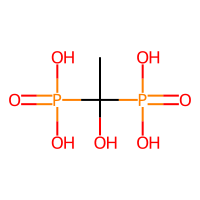
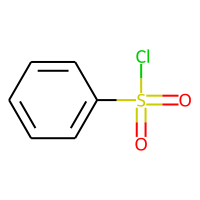
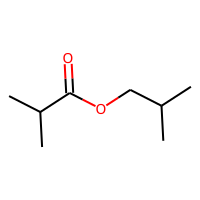
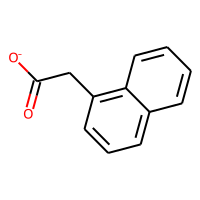
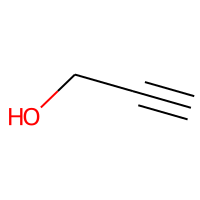

In [19]:
tox21_dataset.head()

In [20]:
#Generate data exploration
tox21_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 3 to 7810
Data columns (total 15 columns):
cano_smiles      3068 non-null object
NR-AR            3068 non-null float64
NR-AR-LBD        3068 non-null float64
NR-AhR           3068 non-null float64
NR-Aromatase     3068 non-null float64
NR-ER            3068 non-null float64
NR-ER-LBD        3068 non-null float64
NR-PPAR-gamma    3068 non-null float64
SR-ARE           3068 non-null float64
SR-ATAD5         3068 non-null float64
SR-HSE           3068 non-null float64
SR-MMP           3068 non-null float64
SR-p53           3068 non-null float64
group            3068 non-null object
Molecule         3068 non-null object
dtypes: float64(12), object(3)
memory usage: 383.5+ KB


### Morgan Fingerprint generation
A fingerprint is generated for each compound in the "Molecule" column with a radius of 2 and a bit length of 2048.

In [21]:
#create a column for Morgan fingerprints
n_Bits = 2048
tox21_dataset["MorgFP"] = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits = n_Bits, useFeatures=True) for m in tox21_dataset['Molecule']] ## Molecule genaration

C:\Users\areej\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
tox21_dataset["MorgFP"].head()

3     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5     [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
11    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
13    [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
20    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: MorgFP, dtype: object

In [23]:
type(tox21_dataset["MorgFP"])

pandas.core.series.Series

In [24]:
tox21_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 3 to 7810
Data columns (total 16 columns):
cano_smiles      3068 non-null object
NR-AR            3068 non-null float64
NR-AR-LBD        3068 non-null float64
NR-AhR           3068 non-null float64
NR-Aromatase     3068 non-null float64
NR-ER            3068 non-null float64
NR-ER-LBD        3068 non-null float64
NR-PPAR-gamma    3068 non-null float64
SR-ARE           3068 non-null float64
SR-ATAD5         3068 non-null float64
SR-HSE           3068 non-null float64
SR-MMP           3068 non-null float64
SR-p53           3068 non-null float64
group            3068 non-null object
Molecule         3068 non-null object
MorgFP           3068 non-null object
dtypes: float64(12), object(4)
memory usage: 407.5+ KB


## Obtain descriptors

**- DescriptorCalculator(): Various bits and pieces for calculating descriptors.**
**- CalcDescriptors(): 

In [25]:
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
descriptors = list(np.array(Descriptors._descList)[:,0])
print(np.array(Descriptors._descList)[:,0])

['MaxEStateIndex' 'MinEStateIndex' 'MaxAbsEStateIndex' 'MinAbsEStateIndex'
 'qed' 'MolWt' 'HeavyAtomMolWt' 'ExactMolWt' 'NumValenceElectrons'
 'NumRadicalElectrons' 'MaxPartialCharge' 'MinPartialCharge'
 'MaxAbsPartialCharge' 'MinAbsPartialCharge' 'FpDensityMorgan1'
 'FpDensityMorgan2' 'FpDensityMorgan3' 'BCUT2D_MWHI' 'BCUT2D_MWLOW'
 'BCUT2D_CHGHI' 'BCUT2D_CHGLO' 'BCUT2D_LOGPHI' 'BCUT2D_LOGPLOW'
 'BCUT2D_MRHI' 'BCUT2D_MRLOW' 'BalabanJ' 'BertzCT' 'Chi0' 'Chi0n' 'Chi0v'
 'Chi1' 'Chi1n' 'Chi1v' 'Chi2n' 'Chi2v' 'Chi3n' 'Chi3v' 'Chi4n' 'Chi4v'
 'HallKierAlpha' 'Ipc' 'Kappa1' 'Kappa2' 'Kappa3' 'LabuteASA' 'PEOE_VSA1'
 'PEOE_VSA10' 'PEOE_VSA11' 'PEOE_VSA12' 'PEOE_VSA13' 'PEOE_VSA14'
 'PEOE_VSA2' 'PEOE_VSA3' 'PEOE_VSA4' 'PEOE_VSA5' 'PEOE_VSA6' 'PEOE_VSA7'
 'PEOE_VSA8' 'PEOE_VSA9' 'SMR_VSA1' 'SMR_VSA10' 'SMR_VSA2' 'SMR_VSA3'
 'SMR_VSA4' 'SMR_VSA5' 'SMR_VSA6' 'SMR_VSA7' 'SMR_VSA8' 'SMR_VSA9'
 'SlogP_VSA1' 'SlogP_VSA10' 'SlogP_VSA11' 'SlogP_VSA12' 'SlogP_VSA2'
 'SlogP_VSA3' 'SlogP_VSA4' 'SlogP_VS

In [26]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)
# Define a custom function to calculate molecular descriptors
def computeDescriptors(mol, calculator):
    res = list(calculator.CalcDescriptors(mol))
    if not np.all(np.isfinite(res)):
        return None  
# Make it's easier to identify problematic molecules (e.g.: infinty descriptor values) later 
    return res

C:\Users\areej\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cano_smiles,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,group,Molecule,MorgFP,Descriptors
3,P(O)(O)(=O)C(P(O)(O)=O)(O)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10.251875, -5.1977237654321, 10.251875, 0.383..."
5,ClS(=O)(=O)c1ccccc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,,"[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[10.598302469135803, -3.5306018518518507, 10.5..."
11,O(C(=O)C(C)C)CC(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10.825046296296296, -0.10305555555555523, 10...."
13,O=C([O-])Cc1c2c(ccc1)cccc2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train,,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[10.50128448601663, -1.0404138321995455, 10.50..."
20,OCC#C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7.638888888888889, -0.15277777777777768, 7.63..."

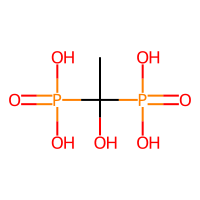
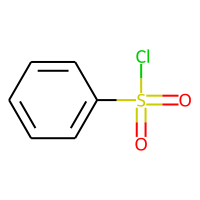
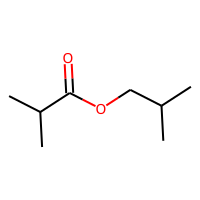
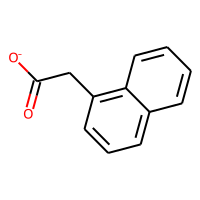
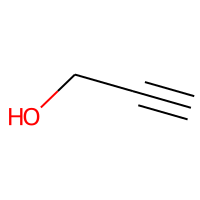

In [27]:
# Compute the descriptors
tox21_dataset['Descriptors'] = tox21_dataset['Molecule'].map(lambda x: computeDescriptors(x,calculator))
# Remove rows with non-finite descriptor values (seems to be only 1 by comparing the counts)
tox21_dataset = tox21_dataset[tox21_dataset['Descriptors'].map(lambda x: x is not None)]
tox21_dataset.head()

In [28]:
df_descriptors = pd.DataFrame(descriptors, columns=['desc_name'])
df_descriptors

,desc_name
0,MaxEStateIndex
1,MinEStateIndex
2,MaxAbsEStateIndex
3,MinAbsEStateIndex
4,qed
...,...
203,fr_thiazole
204,fr_thiocyan
205,fr_thiophene
206,fr_unbrch_alkane


In [29]:
desc_name = [df_descriptors['desc_name'][i] for i in range(len(df_descriptors))]
desc_val = [list(l) for l in tox21_dataset['Descriptors']]
df_desc = pd.DataFrame(desc_val, index = tox21_dataset.index, columns=desc_name)
df_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
3,10.251875,-5.197724,10.251875,0.383488,0.365583,206.027,197.963,205.974526,68,0,...,0,0,0,0,0,0,0,0,0,0
5,10.598302,-3.530602,10.598302,0.135802,0.609724,176.624,171.584,175.969878,54,0,...,0,0,0,0,0,0,0,0,0,0
11,10.825046,-0.103056,10.825046,0.001157,0.564836,144.214,128.086,144.115030,60,0,...,0,0,0,0,0,0,0,0,0,0
13,10.501284,-1.040414,10.501284,0.026435,0.703273,185.202,176.130,185.060803,70,0,...,0,0,0,0,0,0,0,0,0,0
20,7.638889,-0.152778,7.638889,0.152778,0.374690,56.064,52.032,56.026215,22,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
df_desc['group'] = tox21_dataset[['group']].copy()

In [31]:
df_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,group
3,10.251875,-5.197724,10.251875,0.383488,0.365583,206.027,197.963,205.974526,68,0,...,0,0,0,0,0,0,0,0,0,train
5,10.598302,-3.530602,10.598302,0.135802,0.609724,176.624,171.584,175.969878,54,0,...,0,0,0,0,0,0,0,0,0,train
11,10.825046,-0.103056,10.825046,0.001157,0.564836,144.214,128.086,144.115030,60,0,...,0,0,0,0,0,0,0,0,0,train
13,10.501284,-1.040414,10.501284,0.026435,0.703273,185.202,176.130,185.060803,70,0,...,0,0,0,0,0,0,0,0,0,train
20,7.638889,-0.152778,7.638889,0.152778,0.374690,56.064,52.032,56.026215,22,0,...,0,0,1,0,0,0,0,0,0,train


In [32]:
#Finds Null data in any row if any
sample_incomplete_rows = df_desc[df_desc.isnull().any(axis=1)]
sample_incomplete_rows.head(len(sample_incomplete_rows))

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,group


In [33]:
df_desc.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.0,...,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000,3033.000000
mean,9.398391,-0.687393,9.398391,0.386495,0.546368,218.012243,202.858676,217.716411,81.206726,0.0,...,0.030333,0.037587,0.007254,0.004946,0.001649,0.009232,0.000989,0.005605,0.697659,0.030333
std,2.930216,1.526086,2.930216,0.477714,0.164625,125.061337,118.870498,124.921261,44.889925,0.0,...,0.189787,0.213121,0.092318,0.070162,0.040575,0.099041,0.031440,0.078962,2.219914,0.191516
min,1.500000,-9.243265,1.500000,0.000000,0.012914,32.042000,28.010000,32.026215,14.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.316064,-1.059028,8.316064,0.088273,0.439109,139.110000,128.086000,139.026943,52.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.333207,-0.348750,10.333207,0.230619,0.542072,186.363000,174.091000,186.161980,70.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.358902,0.254630,11.358902,0.537037,0.660542,266.381000,248.226000,266.178299,100.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.645307,4.000000,15.645307,8.026720,0.944994,1950.681000,1904.313000,1949.500417,592.000000,0.0,...,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,24.000000,4.000000


### Splitting and Visualizing the data

# Splite the data


In [34]:
#Returns the training set
X_train = df_desc[df_desc["group"]=="train"]
y_train = tox21_dataset[tox21_dataset["group"]=="train"]

In [35]:
#Returns the test set
X_test = df_desc[df_desc["group"]=="test"]
y_test = tox21_dataset[tox21_dataset["group"]=="test"]

In [36]:
#Returns the valid set
X_valid = df_desc[df_desc["group"]=="valid"]
y_valid = tox21_dataset[tox21_dataset["group"]=="valid"]

In [37]:
# Specifing the columns for dependent and independent variables (Training dataset)
X_train = X_train.drop(['group'], axis=1)

In [38]:
y_train = y_train.drop(['group', 'cano_smiles', 'Molecule', 'Descriptors', 'MorgFP'], axis=1)

In [39]:
# Specifing the columns for dependent and independent variables (validation dataset)
X_valid = X_valid.drop(['group'], axis=1)

In [40]:
y_valid = y_valid.drop(['group', 'cano_smiles', 'Molecule', 'Descriptors', 'MorgFP'], axis=1)

In [41]:
# Specifing the columns for dependent and independent variables (test dataset)
X_test = X_test.drop(['group'], axis=1)

In [42]:
y_test = y_test.drop(['group', 'cano_smiles', 'Molecule', 'Descriptors', 'MorgFP'], axis=1)

In [43]:
categories = list(y_test.columns.values)

In [44]:
categories

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

**Convert the RDKit explicit vectors into numpy arrays**

In [45]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)
#y_train = np.array(y_train)
#y_test = np.array(y_test)
#y_valid = np.array(y_valid)

In [46]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))
print(type(X_valid))
print(type(y_valid))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [47]:
print(X_train.shape, y_train.shape)

(2403, 208) (2403, 12)


In [48]:
print(X_valid.shape, y_valid.shape)

(318, 208) (318, 12)


In [49]:
print(X_test.shape, y_test.shape)

(312, 208) (312, 12)


## Feature Scaling

In [50]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(RandomForestClassifier(random_state = 42), n_jobs=-1)),
            ])

In [52]:
for category in categories:
    print('Processing {} results:'.format(category))
    
    LogReg_pipeline.fit(X_train, y_train[category].values)
    
    # Calculating the accuracy
    prediction_train = LogReg_pipeline.predict(X_train)
    prediction_valid = LogReg_pipeline.predict(X_valid)
    prediction_test = LogReg_pipeline.predict(X_test)
    try:
        print('Train accuracy is {}'.format(roc_auc_score(y_train[category].values, prediction_train)))
        
    except ValueError:
        print("Train accuracy not defined...")
    
    try:
        print('Valid accuracy is {}'.format(roc_auc_score(y_valid[category].values, prediction_valid)))
    except ValueError:
        print("Valid accuracy is not defined...")
        
    try: 
        print('Test accuracy is {}'.format(roc_auc_score(y_test[category].values, prediction_test)))
        print("\n")
    except ValueError:
        print("Test accuracy is not defined...")
        print("\n")

Processing NR-AR results:
Train accuracy is 0.9651162790697674
Valid accuracy is 0.6233870967741936
Test accuracy is 0.5625


Processing NR-AR-LBD results:
Train accuracy is 0.9807692307692308
Valid accuracy is 0.6666666666666666
Test accuracy is 0.6


Processing NR-AhR results:
Train accuracy is 1.0
Valid accuracy is 0.5421972164643174
Test accuracy is 0.5482876712328767


Processing NR-Aromatase results:
Train accuracy is 1.0
Valid accuracy is 0.5
Test accuracy is 0.5


Processing NR-ER results:
Train accuracy is 0.994535519125683
Valid accuracy is 0.5449027762167021
Test accuracy is 0.5873294346978557


Processing NR-ER-LBD results:
Train accuracy is 0.9897959183673469
Valid accuracy is 0.6650485436893204
Test accuracy is 0.6666666666666666


Processing NR-PPAR-gamma results:
Train accuracy is 1.0
Valid accuracy is 0.5
Test accuracy is 0.5


Processing SR-ARE results:
Train accuracy is 1.0
Valid accuracy is 0.4983388704318937
Test accuracy is 0.5476190476190477


Processing SR-ATAD5

In [53]:
#SR-ATAD5 
sum_y_test = sum(y_test["SR-ATAD5"].values)
sum_y_test

0.0

In [54]:
print("Done")

Done
